In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os
import glob
import bayes3d.neural
import pickle
# Can be helpful for debugging:
# jax.config.update('jax_enable_checks', True) 
from bayes3d.neural.segmentation import carvekit_get_foreground_mask
import genjax

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7023/static/


In [3]:
importance_jit = jax.jit(b.model.importance)
key = jax.random.PRNGKey(10)

In [75]:
paths = glob.glob(
    "panda_scans_v6/*.pkl"
)
all_data = pickle.load(open(paths[0], "rb"))
IDX = 0
data = all_data[IDX]

dict_keys(['rgbPixels', 'depthPixels', 'segmentationMaskBuffer', 'camera_pose', 'camera_matrix'])


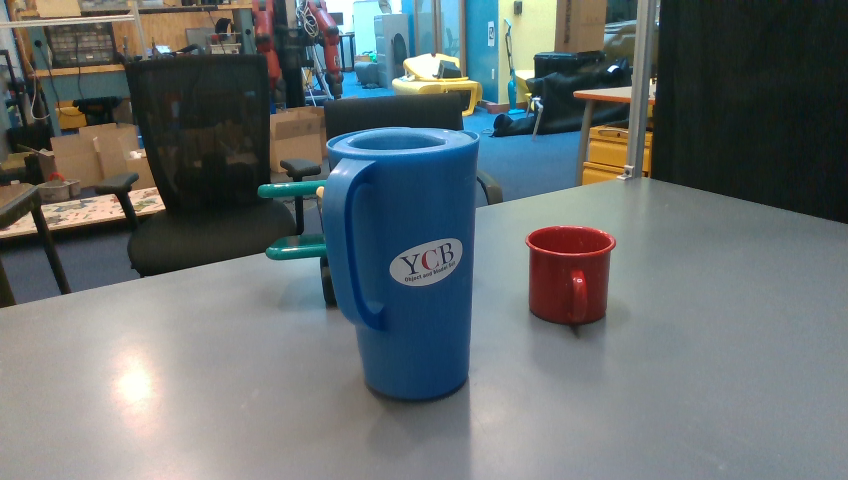

In [76]:
print(data["camera_image"].keys())
K = data["camera_image"]['camera_matrix'][0]
rgb = data["camera_image"]['rgbPixels']
depth = data["camera_image"]['depthPixels']
camera_pose = data["camera_image"]['camera_pose']
camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
h,w = depth.shape
near = 0.001
rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,0.001,10000.0))
b.get_rgb_image(rgbd_original.rgb)

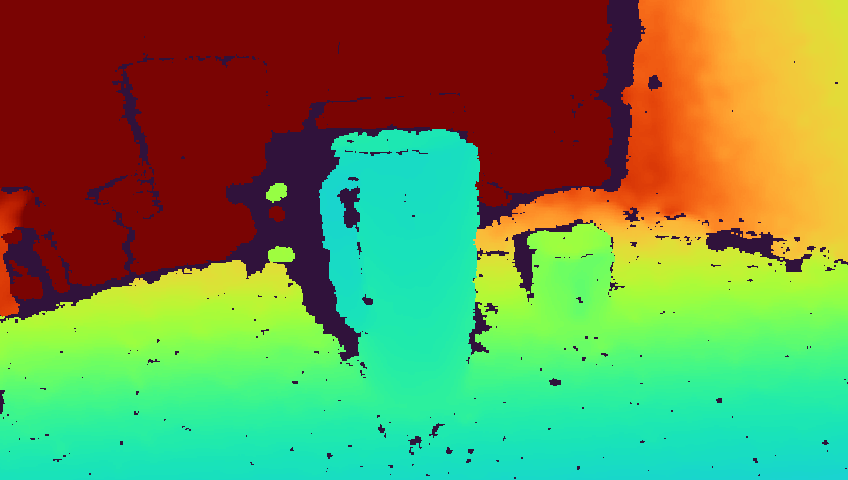

In [77]:
b.get_depth_image(rgbd_original.depth,max=1.5)

In [78]:
scaling_factor = 0.2
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)

In [100]:
plane_pose, plane_dims = b.utils.find_plane_and_dims(
    b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics).reshape(-1,3), 
    ransac_threshold=0.001, inlier_threshold=0.001, segmentation_threshold=0.1
)

In [113]:
plane_pose = plane_pose @ b.transform_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), jnp.pi)

In [102]:
b.clear()
b.show_cloud("1", b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics).reshape(-1,3))
b.show_pose("table", plane_pose)

In [103]:
mask = b.utils.scale(carvekit_get_foreground_mask(rgbd_original)*1.0, scaling_factor)

In [104]:
observed_depth = (rgbd_scaled_down.depth * mask) + (1.0 - mask)* rgbd_scaled_down.intrinsics.far

In [105]:
b.clear()
b.show_cloud("1", b.unproject_depth(observed_depth, rgbd_scaled_down.intrinsics).reshape(-1,3))
b.show_pose("table", plane_pose)

In [106]:
b.utils.ycb_loader.MODEL_NAMES[10]

'019_pitcher_base'

In [107]:
b.setup_renderer(rgbd_scaled_down.intrinsics)
b.RENDERER.add_mesh_from_file("toy_plane.ply")
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(10+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (192, 96, 1024)
Centering mesh with translation [0.   0.   0.09]


In [108]:
for i in range(len(b.RENDERER.meshes)):
    b.show_trimesh(f"mesh_{i}", b.RENDERER.meshes[i])

In [109]:
grid_params = [
    (0.3, jnp.pi, (11,11,11)), (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi, (11,11,11)),
    (0.05, jnp.pi/3, (11,11,11)), (0.02, jnp.pi, (5,5,51)), (0.01, jnp.pi/5, (11,11,11)), (0.01, 0.0, (21,21,1)),(0.05, 0.0, (21,21,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]


In [114]:
weight, trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "id_0": jnp.int32(3),
    "camera_pose": jnp.eye(4),
    "root_pose_0": plane_pose,
    "face_parent_1": 2,
    "face_child_1": 3,
    "image": b.unproject_depth(observed_depth, rgbd_scaled_down.intrinsics),
    "variance": 0.0001,
    "outlier_prob": 0.0001,
    "contact_params_1": jnp.array([0.0, 0.0, 0.0])
}), (
    jnp.arange(1),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, 1.0, 1.0)
)
b.viz_trace_meshcat(trace)
print(trace.get_score())

4237.054


In [118]:
OBJECT_NUMBER = 2
address = f"contact_params_{OBJECT_NUMBER}"
enumerators = b.make_enumerator([address])

In [119]:
trace = b.add_object_jit(trace, key, 1, 0, 2,3)
b.viz_trace_meshcat(trace)

In [120]:
for idx in range(len(contact_param_gridding_schedule)):
    contact_param_deltas = contact_param_gridding_schedule[idx]
    contact_param_grid = contact_param_deltas + trace[address]
    scores = enumerators[3](trace, key, contact_param_grid)
    i= jnp.unravel_index(scores.argmax(), scores.shape)
    trace = enumerators[0](
        trace, key,
        contact_param_grid[i]
    )
    b.viz_trace_meshcat(trace)

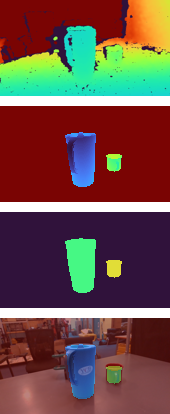

In [121]:
depth_viz = b.viz.resize_image(b.get_depth_image(rgbd_original.depth,max=1.5), b.RENDERER.intrinsics.height, b.RENDERER.intrinsics.width)
depth_reconstruction_viz = b.get_depth_image(b.get_rendered_image(trace)[...,2], max=1.0)
seg_viz = b.get_depth_image(b.RENDERER.render(b.get_poses(trace), b.get_indices(trace))[:,:,3], max=5.0)
rgb_viz = b.resize_image(b.get_rgb_image(rgbd_original.rgb), b.RENDERER.intrinsics.height, b.RENDERER.intrinsics.width)
overlay_viz = b.overlay_image(b.viz.resize_image(depth_reconstruction_viz, rgb_viz.height,rgb_viz.width), rgb_viz)
b.vstack_images([
    depth_viz,
    depth_reconstruction_viz,
    seg_viz,
    overlay_viz
])
    